# Classification of mammo tiles by one-hot-encoding

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import pandas as pd
import numpy as np
import cv2
from pathlib import *
import colorcet as cc

In [5]:
torch.backends.cudnn.enabled

True

In [1]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [7]:
cmap_grey = cc.cm.linear_grey_0_100_c0
clientside = True

In [8]:
def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        drawnIndex = min(df.shape[0], nb, len(idx) )
        #print(f"df.shape:{df.shape} idx.shape:{idx.shape} numbers:{drawnIndex}")
        idx   = idx[0:drawnIndex]
        #idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=min(df.shape[0],nb)).astype(int))
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll
    #return dfAll.loc[:,["purpose", "fnImage", "classes"]]
    
class GrayImageReader(ImageReader):
    def __init__(self): super().__init__(outChannels=1)
        
    def open(self, fn):
        im = cv2.imread(str(fn),cv2.IMREAD_ANYDEPTH)
        #fastai expect 3 dimension as for jpgs
        return np.expand_dims(im,2)/65536.0

class MaskImageReader(ImageReader):
    def __init__(self):
        super().__init__(outChannels=1)
        
    def open(self, fn):
        return cv2.imread(str(fn), cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR)    

In [9]:
PATH = Path("D:/Dropbox/x-ray/CBIS-DDSM-mammography/equalized2dg_tiles")
if clientside:
#    PATH = Path("../../x-ray/CBIS-DDSM-mammography/CBIS_DDSM_tiled")
    cases = pd.read_csv( PATH / "tiles.csv", sep=";")
    cases.drop("Unnamed: 0",axis=1,inplace=True)
    cases["calc type - mass_shape"]=cases["calc type - mass_shape"].astype(str)
    cases["calc distribution - mass margins"]=cases["calc distribution - mass margins"].astype(str)
#    cases = pd.read_csv( PATH / "tiles.csv", sep=";")
    #start = len("CBIS_DDSM_tiled/tiles/")
    #start = len("equalized2dg_tiles/tiles/")
    #cases.fnImage = cases.fnImage.str[start:]
    #cases.fnMask  = cases.fnMask.str[start:]
    display(cases.head(2))
else:    
    PATH = Path("D:/Dropbox/x-ray/CBIS-DDSM-mammography/equalized2dg_tiles/mammo_subset") 

gp = cases.groupby( ["purpose", "simple_pathology"])["fnImage"].count()
print( gp )


C:\Users\kl\Anaconda3\envs\kl-fastai\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,case_id,height,width,simple_pathology,patient_id,purpose,breast density,left or right breast,image view,abnormality id,...,pAir,pHealthy,pBenign,pMalignant,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask
0,Calc-Test_P_00038_LEFT_CC,3601,1296,BENIGN,P_00038,test,2.0,LEFT,CC,1,...,5880,44296,0,0,0.06,0.17,50176,0,test/Calc-Test_P_00038_LEFT_CC_tile_0_0.png,test/Calc-Test_P_00038_LEFT_CC_tile_0_0.png
1,Calc-Test_P_00038_LEFT_CC,3601,1296,BENIGN,P_00038,test,2.0,LEFT,CC,1,...,0,50176,0,0,0.19,0.17,50176,0,test/Calc-Test_P_00038_LEFT_CC_tile_224_0.png,test/Calc-Test_P_00038_LEFT_CC_tile_224_0.png


purpose  simple_pathology          
test     BENIGN                        19648
         BENIGN;MALIGNANT                258
         MALIGNANT                     13623
train    BENIGN                        70904
         BENIGN;MALIGNANT                251
         BENIGN;MALIGNANT;MALIGNANT      177
         MALIGNANT                     55902
         MALIGNANT;BENIGN                354
Name: fnImage, dtype: int64


In [10]:
print(cases.columns)
cases['calc distribution - mass margins'] = cases['calc distribution - mass margins'].astype(np.str)

Index(['case_id', 'height', 'width', 'simple_pathology', 'patient_id',
       'purpose', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type - mass_shape',
       'calc distribution - mass margins', 'assessment', 'pathology',
       'subtlety', 'tile_id', 'pAir', 'pHealthy', 'pBenign', 'pMalignant',
       'rCenter', 'cCenter', 'tile_size', 'obsAreas', 'fnImage', 'fnMask'],
      dtype='object')


In [11]:
#### serverside training
"""
print(clientside)

if clientside:
    
    ixKeep = cases.fnImage.str.contains("Mass")
#    ixKeep = cases.fnImage.str.contains("Calc")
    cases = cases[ixKeep]
    print(sum(ixKeep))
    
else:
    #list(PATH.iterdir())
    cases = pd.read_csv( PATH / "caseSelection.csv")
"""

complexity={
#            "pAir":"pAir>0.2 and pAir<1.0", 
            "pHealthy":"pAir==0 and pBenign==0 and pMalignant==0",
#            "pBenign":"pBenign/tile_size>0.4 and pMalignant==0 and pAir==0"
            "pMalignant":"pMalignant > 0.01*tile_size and pMalignant > 0.62*obsAreas and pBenign==0 and pAir==0"
#            "pMalignant":"pMalignant > 0.99*obsAreas and pBenign==0 and pAir==0"
}
nb=1000
test  = selectCases( cases, "test",     complexity=complexity, nb=nb//2 )
train = selectCases( cases, "train", complexity=complexity, nb=nb )
cases = train.append( test, ignore_index=False )
cases.reset_index(drop=True,inplace=True)

print(f"Total: {cases.shape[0]}")
gp = cases.groupby( ["purpose", "classes"])["fnImage"].count()
print( gp )


#csv_path=PATH / "tiles"
#os.makedirs(csv_path, exist_ok=True)
if clientside:
    cases.to_csv(PATH / "caseSelection.csv", index=False)

#generate training and validation csv for fastai
tvData = cases.loc[: , ["fnImage", "classes"]]
tvData.to_csv( PATH / "tvData.csv", index=False)
tvData.head(2)

Total: 3000
purpose  classes   
test     pHealthy       500
         pMalignant     500
train    pHealthy      1000
         pMalignant    1000
Name: fnImage, dtype: int64


,fnImage,classes
0,train/Calc-Training_P_00005_RIGHT_CC_tile_448_...,pHealthy
1,train/Calc-Training_P_00005_RIGHT_CC_tile_1344...,pHealthy


In [12]:
class TransformStat( Transform ):
    #displace as absolute number
    #prob of displacement
    def __init__(self, tfm_y=TfmType.NO):
        super().__init__(tfm_y=tfm_y)
        self.nStateCount=0
        self.nTfmCount=0

    def set_state(self): self.nStateCount += 1
    def do_transform(self, x, is_y): self.nTfmCount += 1
    def stateCount(self): return self.nStateCount
    def tfmCount(self): return self.nTfmCount
    def tfmRatio(self): return round(self.nTfmCount / self.nStateCount,2) if self.nStateCount>0 else 0
    def stats(self): return f"transform ratio:{self.tfmRatio()} = {self.tfmCount()} of {self.stateCount()} calls"

class RandomHistogramDisplacement( TransformStat ):
    #displace as absolute number
    #prob of displacement
    def __init__(self, tfm_y=TfmType.NO, displace=0.1, prob=0.5):
        super().__init__(tfm_y=tfm_y)
        self.p=prob
        self.d=displace
    def set_state(self): 
        super().set_state()
        self.store.do_tfm = random.random() < self.p
    def do_transform(self, x, is_y): 
        if self.store.do_tfm : 
            super().do_transform(x, is_y)
            x = x+random.uniform(-self.d,self.d)
#            x = x+random.uniform(-self.d,self.d)
        return x

class RandomHistogramAccordion( TransformStat ):
    #accord is the +-contraction and expansion factor
    #prob of displacement
    def __init__(self, tfm_y=TfmType.NO, accord=0.1, prob=0.5):
        super().__init__(tfm_y=tfm_y)
        self.p=prob
        self.a=accord

    def set_state(self): 
        super().set_state()
        self.store.do_tfm = random.random() < self.p
    def do_transform(self, x, is_y): 
        if self.store.do_tfm : 
            super().do_transform(x, is_y)
            x = x*(1+random.uniform(-self.a,self.a))
        return x

class RandomInverseHistogram( TransformStat ):
    def __init__(self, tfm_y=TfmType.NO, prob=0.5):
        super().__init__(tfm_y=tfm_y)
        self.p=prob

    def set_state(self): 
        super().set_state()
        self.store.do_tfm = random.random() < self.p
    def do_transform(self, x, is_y): 
        if self.store.do_tfm : 
            super().do_transform(x, is_y)
            x = -x
        return x


class RandomSelfMixin( TransformStat ):
    #accord is the +-contraction and expansion factor
    #prob of displacement
    def __init__(self, tfm_y=TfmType.NO, mixRatio=0.1, prob=0.5):
        super().__init__(tfm_y=tfm_y)
        self.p=prob
        self.r=mixRatio
        self.ix = None
        
    def set_state(self): 
        super().set_state()
        self.store.do_tfm = random.random() < self.p
        
    def do_transform(self, x, is_y): 
        if self.store.do_tfm :
            super().do_transform(x, is_y)
            if self.ix is None : self.ix = np.arange(len(x.flatten())).astype(np.int32)
            cv2.randShuffle(self.ix)
            ratio = random.uniform(0, self.r)
            xf = x.flatten()
            x = (xf * (1-ratio) + xf[self.ix] *ratio).reshape(x.shape)
        return x

# mixing with a transformed copy of th image
class SuperDiheral( RandomDihedral ):
    #accord is the +-contraction and expansion factor
    #prob of displacement
    def __init__(self, tfm_y=TfmType.NO, mixRatio=0.1, prob=0.5):
        super().__init__(tfm_y=tfm_y)
        self.p=prob
        self.r=mixRatio
        
    def do_transform(self, x, is_y): 
        if self.store.do_flip :
            xc = super().do_transform(x, is_y)
            ratio = random.uniform(0, self.r)
            x = (x * (1-ratio) + xc*ratio).reshape(x.shape)
        return x


In [13]:
# setup train against output classes
asGreyScale = True
imagechannels = 1 if asGreyScale else 3
imageReader = GrayImageReader()
sz=224
bs=32
CSV = PATH/"tvData.csv"
arch = ConvnetBuilder(resnet34,asGreyScale)
acccordion    = RandomHistogramAccordion(accord=0.3, prob=0.5)
displacement  = RandomHistogramDisplacement(displace=0.3, prob=0.5)
selfMixin     = RandomSelfMixin(mixRatio=0.15, prob=0.5)
zoom          = RandomZoom(zoom_max=0.2)
stretch       = RandomStretch(max_stretch=0.2)
superDihedral = SuperDiheral(mixRatio=0.2, prob=0.75)
#rotzoom       = RandomRotateZoom(deg=5, zoom=0.2, stretch=0.2, ps = [0.25,0.5,0.25,0.25])
#inverseHistogram = RandomInverseHistogram(prob=0.25)
aug_tfms = [
#    RandomLighting(0.05, 0.05),
#    RandomRotate(10),
#    inverseHistogram,
#    superDihedral,
#    rotzoom,
    
    selfMixin,
    zoom,
    stretch,
    acccordion,
    displacement,
    RandomDihedral()
]
#aug_tfms = None
#transforms_side_on  = transforms_basic + [RandomFlip()]

#the normalization that we calcualted for our grayscale images
normalizationStats = np.asarray([0.446, 0.24])

tfms = tfms_from_stats(normalizationStats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
val_idxs = tvData.fnImage.str.startswith("test")
val_idxs = np.arange(len(val_idxs))[val_idxs]
precompute=False
data = ImageClassifierData.from_csv( imageReader, PATH, folder="tiles", csv_fname=CSV, \
                                     val_idxs=val_idxs, tfms=tfms, bs=bs )
learn = ConvLearner.pretrained(arch, data, precompute=precompute)
#learn.opt_fn = optim.Adam


In [14]:
#learn.fit(1e-2, 3, cycle_len=1)
lrf=learn.lr_find()

 87%|█████████████████████████████████████████████████████████████▉         | 55/63 [00:03<00:00, 22.71it/s, loss=3.28]


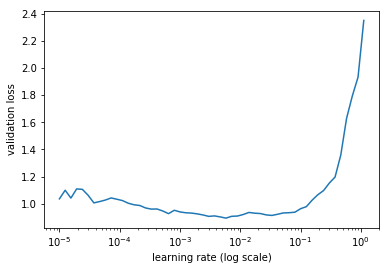

In [15]:
learn.sched.plot(n_skip=0, n_skip_end=0)

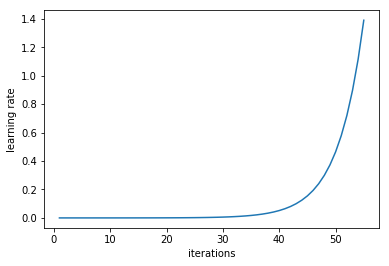

In [16]:
learn.sched.plot_lr()

In [17]:

#learn.fit(0.01, 30, wds=0.025, use_wd_sched=True, use_swa=True, swa_start=20) 
learn.fit(0.1, 20, wds=1e-4) 
#learn.fit(0.01, n_cycle=3, cycle_len=1, cycle_mult=2 ) 

#learn.fit(0.001, 20, wds=0.025, use_wd_sched=True) # for adamw looks not so good

#learn.fit(0.01, n_cycle=3, cycle_len=2, cycle_mult=2, wds=0.025, use_wd_sched=True) # works very well 3-4 cycles are enough

#learn.fit(0.01, n_cycle=3, cycle_len=3, cycle_mult=2, wds=0.025, use_wd_sched=True) # sgdw: works ok 

#%time learn.fit(lrs=0.01, n_cycle=1, wds=0.025,  use_wd_sched=True, cycle_len=10, use_clr_beta=(20, 10, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.217346   1.215612   0.565     
    1      1.324349   0.629702   0.622                                                                                 
    2      0.884109   0.674885   0.621                                                                                 
    3      0.758572   0.753656   0.516                                                                                 
    4      0.695358   0.626734   0.653                                                                                 
    5      0.668467   0.60697    0.668                                                                                 
    6      0.656519   0.604056   0.668                                                                                 
    7      0.656229   0.599886   0.692                                                                              

[0.5623819594383239, 0.717]

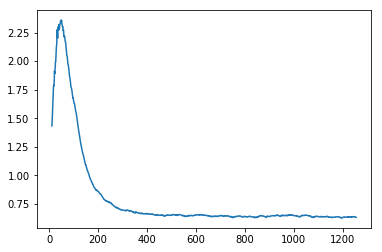

In [18]:
learn.sched.plot_loss()

In [19]:
print(selfMixin.stats())
print(acccordion.stats())
print(displacement.stats())

transform ratio:0.5 = 21025 of 42000 calls
transform ratio:0.5 = 20969 of 42000 calls
transform ratio:0.5 = 20871 of 42000 calls


In [20]:
learn.precompute=False
learn.unfreeze()
#lr=np.array([1e-4,1e-3,1e-2])

lr=np.array([1e-2,0,0])
learn.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=1e-4) 
lr=np.array([1e-3,1e-2,0])
learn.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=1e-4) 
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, n_cycle=7, cycle_len=1, cycle_mult=2, wds=1e-4, use_swa=True, swa_start=20) 


#learn.fit(lr, 8, cycle_len=1, cycle_mult=2, use_swa=True, swa_start=200)

#learn.fit(lr, n_cycle=4, cycle_len=3, cycle_mult=2, wds=0.025, use_wd_sched=True) #ok with adam
#learn.fit(lr, 2, cycle_len=3, cycle_mult=2, wds=0.05, use_wd_sched=True)

#%time learn.fit(lrs=lr, n_cycle=1, wds=0.025,  use_wd_sched=True,  cycle_len=10, use_clr_beta=(50, 10, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.742285   0.646911   0.642     
    1      0.743107   0.671034   0.653                                                                                 
    2      0.745688   0.634204   0.674                                                                                 
    3      0.762268   0.62265    0.668                                                                                 
    4      0.748442   0.649043   0.628                                                                                 
    5      0.733554   0.625001   0.66                                                                                  
    6      0.727158   0.619971   0.67                                                                                  



epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.748026   0.640875   0.642     
    1      0.73262    0.639449   0.628                                                                                 
    2      0.71216    0.595098   0.681                                                                                 
    3      0.724666   0.615103   0.662                                                                                 
    4      0.715004   0.609222   0.654                                                                                 
    5      0.685002   0.596759   0.682                                                                                 
    6      0.676941   0.584866   0.701                                                                                 



epoch      trn_loss   val_loss   accuracy   swa_loss   swa_accuracy                                                    
    0      0.650901   0.589679   0.724     
    1      0.642121   0.585068   0.726                                                                                 
    2      0.641546   0.581029   0.729                                                                                 
    3      0.633451   0.578936   0.727                                                                                 
    4      0.634003   0.577825   0.73                                                                                  
    5      0.627346   0.583743   0.729                                                                                 
    6      0.631465   0.582082   0.735                                                                                 
    7      0.630717   0.576928   0.727                                                                              

[0.5305383288860321, 0.763, 0.5337314925193787, 0.762]

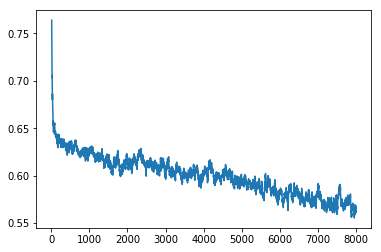

In [21]:
learn.sched.plot_loss()

In [22]:
def show_img(im, title=None,figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    if title is not None : ax.set_title( title, fontsize=10 )
    colorMap = cc.cm.linear_grey_0_100_c0 if im.ndim == 2 else None   
    ax.imshow(im,cmap=colorMap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [23]:
def getCases( data_fnImages ):
    idx_cases = np.arange(cases.shape[0])
    start     = data_fnImages[0].find("test")
    val_idxs  = [np.squeeze(idx_cases[cases.fnImage==f[start:]]) for f in data_fnImages]
    return cases.iloc[val_idxs]
    
def rand_by_mask(mask): 
    ix  = np.where(mask)[0]
    return np.random.choice(ix, min(4,len(ix)), replace=False) if len(ix)>0 else []
#    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): 
    # (preds == data.val_y)
    #rand_by_mask((preds == data.val_y)==is_correct)
    return rand_by_mask((preds == data.val_y)==is_correct)

def plots(mainTitle, ims, figsize=(12,6), rows=1, titles=None):
    nbImages = len(ims)
    print(f"----------------------------- {mainTitle} ----------------------------------------")
    fig,axes = plt.subplots(rows,len(ims)//rows, figsize=figsize)
    for i,ax in enumerate(axes.flat):
        title = titles[i] if titles is not None else None
        show_img(ims[i], title, ax=ax)
    
def load_img_id(ds, idxs): 
    xs,ys = zip(*[ ds.get1item(i) for i in idxs ])
    xs_denorms = [ np.squeeze( np.clip( ds.denorm(x)[0], 0, 1 ) ) for x in xs ]
    return xs_denorms,ys

def plot_val_with_title(idxs, title):
    if len(idxs) == 0 : 
        print( f"Zero cases for: {title}")
        return
    else:
        xs,ys = load_img_id(data.val_ds,idxs)
        rs          = getCases(data.val_ds.fnames[idxs] )
        title_probs = []
        for i in range(idxs.shape[0]): 
            onehot = np.zeros( len(data.classes) ).astype(int)
            onehot[ys[i]] = 1
            s = f"{data.classes[ys[i]]}: {onehot} vs {probs[idxs[i],:]}"
#            s = f"{data.classes[ys[i]]} ({probs[idxs[i]]:.2f}) h,a: {rs.pHealthy.iloc[i]} {rs.pAir.iloc[i]} {rs.pBenign.iloc[i]} {rs.pMalignant.iloc[i]}"
            title_probs.append( s )
        
        rows = 1
        withMasks=False
        if withMasks:
            t = ["" for ix in idxs]
            title_probs.extend(t)
            fnMasks = [ str(PATH/"masks"/r) for r in list(rs.fnMask) ]
            maskReader = MaskImageReader()
            xm      = [ maskReader.open( f ) for f in fnMasks ]
            xs.extend(xm)
            rows = 2
        plots(title, xs, rows=rows, titles=title_probs, figsize=(16,8))
        #print the filenames in case we have to analyze issues
        print("fnImages:\n",np.asarray(list(rs.fnImage)))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    y    = np.asarray(data.val_y[mask])
    #print(y[0:5])
    p=probs[idxs,y]
    print(probs[idxs,y][0:5])
    print(p.shape)
    ix   = idxs[np.argsort(mult * probs[idxs,y])[:4]]
    #print(f"idxs.shape:{idxs.shape} len(y):{len(y)}, mask.shape:{mask.shape} mult:{mult}")
    #print(probs[ix,])
    return  ix

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    # mult = -1 if (y==1)==is_correct else 1
    return most_by_mask( ((preds == data.val_y)==is_correct) & (data.val_y == y), mult )

def mostUncertain(nbCases) :
    ix = np.arange(probs.shape[0])
    #select the target probabilities
    p = probs[ix, data.val_y[ix]]
    return np.argsort(np.abs(p -0.5))[:nbCases]

print(f"data.classes:{data.classes}")
#print(most_by_correct(0, False))
#print(most_by_correct(1, True))


data.classes:['pHealthy', 'pMalignant']


In [24]:
# this gives prediction for validation set. Predictions are in log scale
#log_preds = learn.predict(use_swa=True)
#log_preds_aug,y_aug = learn.TTA(n_aug=20, use_swa=True)
log_preds_aug,y_aug = learn.TTA(n_aug=7, use_swa=True)


In [25]:

#log_preds=np.mean(log_preds_aug,axis=0)
log_preds=np.median(log_preds_aug,axis=0)


In [26]:
probs   = np.round( np.exp(log_preds), 3 ) # probability of predicred
preds   = np.argmax(log_preds, axis=1)     # from log probabilities to 0 or 1
classes = np.asarray(data.classes)

df = pd.DataFrame( columns = ["target", f"prob_{data.classes[0]}", f"prob_{data.classes[1]}", "predicted"] )
df.target    = np.asarray(classes[data.val_y])
df[f"prob_{data.classes[0]}"] = probs[:,0]
df[f"prob_{data.classes[1]}"]      = probs[:,1]
df.predicted = np.asarray(classes[preds])
#df

In [27]:
ix_mismatch = False == (df.target == df.predicted)
df_Mismatch  = df[ix_mismatch]
print("Mismatch statistics\n")
p = round( 100*df_Mismatch.shape[0]/df.shape[0], 1 )
print(f"mismatch count: {df_Mismatch.shape[0]} procent: {p}%" )
gp = df_Mismatch.groupby( ["target", "predicted"])["prob_pHealthy"].count()
print( "count:", gp )

gp = df_Mismatch.groupby( ["target", "predicted"])["prob_pHealthy"].mean()
print( "\nmean prob_target:", gp )

Mismatch statistics

mismatch count: 258 procent: 25.8%
count: target      predicted 
pHealthy    pMalignant    148
pMalignant  pHealthy      110
Name: prob_pHealthy, dtype: int64

mean prob_target: target      predicted 
pHealthy    pMalignant    0.378291
pMalignant  pHealthy      0.642555
Name: prob_pHealthy, dtype: float32


In [28]:
display(df)
print("classes: ", classes)
print(probs)

,target,prob_pHealthy,prob_pMalignant,predicted
0,pHealthy,0.582,0.418,pHealthy
1,pHealthy,0.507,0.493,pHealthy
2,pHealthy,0.598,0.402,pHealthy
3,pHealthy,0.685,0.315,pHealthy
4,pHealthy,0.573,0.427,pHealthy
5,pHealthy,0.781,0.219,pHealthy
6,pHealthy,0.700,0.300,pHealthy
7,pHealthy,0.801,0.199,pHealthy
8,pHealthy,0.717,0.283,pHealthy
9,pHealthy,0.509,0.491,pHealthy


classes:  ['pHealthy' 'pMalignant']
[[0.582 0.418]
 [0.507 0.493]
 [0.598 0.402]
 ...
 [0.293 0.707]
 [0.291 0.709]
 [0.473 0.527]]


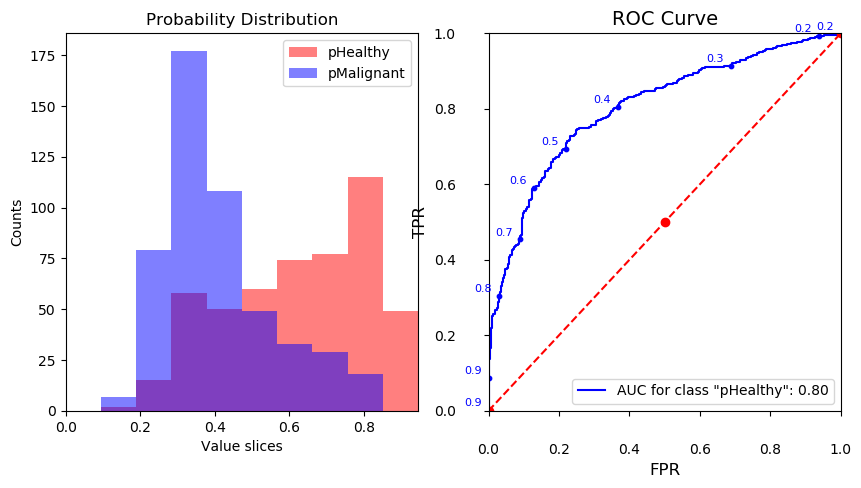

,category,score,true_positive,false_positive,true_negative,false_negative,recall,precision,f1
21,pHealthy,0.945,0.002,0.000,1.000,1.000,0.002,1.000,0.004
98,pHealthy,0.940,0.004,0.000,0.998,1.000,0.004,1.000,0.008
310,pHealthy,0.936,0.006,0.000,0.996,1.000,0.006,1.000,0.012
92,pHealthy,0.935,0.008,0.000,0.994,1.000,0.008,1.000,0.016
18,pHealthy,0.931,0.010,0.000,0.992,1.000,0.010,1.000,0.020
125,pHealthy,0.925,0.012,0.000,0.990,1.000,0.012,1.000,0.023
303,pHealthy,0.914,0.014,0.000,0.988,1.000,0.014,1.000,0.027
187,pHealthy,0.912,0.016,0.000,0.986,1.000,0.016,1.000,0.031
52,pHealthy,0.910,0.018,0.000,0.984,1.000,0.018,1.000,0.035
128,pHealthy,0.910,0.020,0.000,0.982,1.000,0.020,1.000,0.038


In [29]:
import roc
from roc import auc_by_utest, roc_coordinates, auc_by_roc_coordinates, plot_pdf, plot_roc

class_predictions    = { c:np.asarray(df.prob_pHealthy[df.target==c]) for c in classes }
metrics, roc_classes = roc_coordinates( df.target, df.prob_pHealthy, ["pHealthy"])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10,5), dpi=100)
plot_roc( np.asarray(metrics.score), np.asarray(metrics.true_positive), np.asarray(metrics.false_positive), \
         roc_classes[0], ax=ax2, thresh_decimals=1 )
plot_pdf( np.linspace(0,np.max(df.prob_pHealthy),11), class_predictions, colors=["r","b"], ax= ax1)
plt.show()
display(metrics)

#auc_by_utest(df.target, df.prob_pHealthy)

----------------------------- Correctly classified ----------------------------------------
fnImages:
 ['test/Calc-Test_P_00485_LEFT_CC_tile_2060_376.png' 'test/Calc-Test_P_00485_LEFT_CC_tile_1560_870.png'
 'test/Calc-Test_P_00974_RIGHT_CC_tile_1338_244.png' 'test/Calc-Test_P_01148_RIGHT_MLO_tile_1462_502.png']


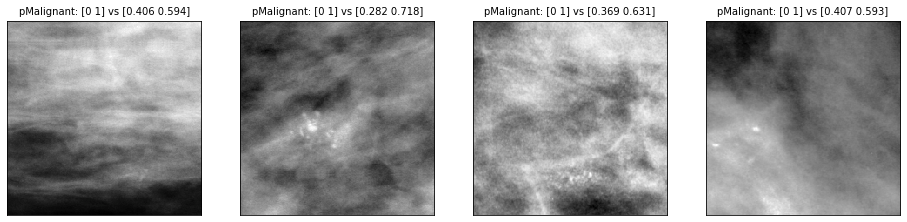

In [30]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True)[0:4], "Correctly classified")

----------------------------- Incorrectly classified ----------------------------------------
fnImages:
 ['test/Calc-Test_P_00127_RIGHT_CC_tile_1120_896.png' 'test/Calc-Test_P_00100_RIGHT_CC_tile_896_224.png'
 'test/Calc-Test_P_00077_RIGHT_MLO_tile_1568_448.png' 'test/Calc-Test_P_00495_RIGHT_CC_tile_1120_448.png']


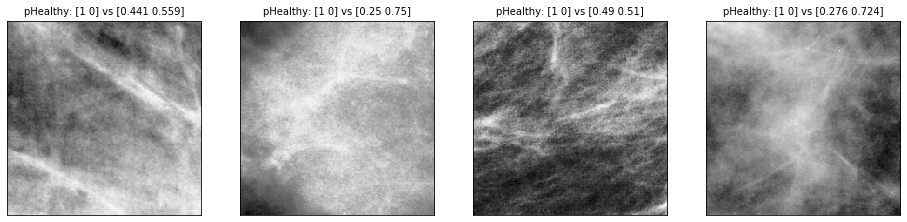

In [31]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

[0.582 0.507 0.598 0.685 0.573]
(352,)
----------------------------- Most correct healthy ----------------------------------------
fnImages:
 ['test/Calc-Test_P_00041_LEFT_CC_tile_1120_224.png' 'test/Calc-Test_P_00140_LEFT_CC_tile_1120_0.png'
 'test/Calc-Test_P_00325_RIGHT_MLO_tile_0_224.png' 'test/Calc-Test_P_00132_LEFT_MLO_tile_672_730.png']


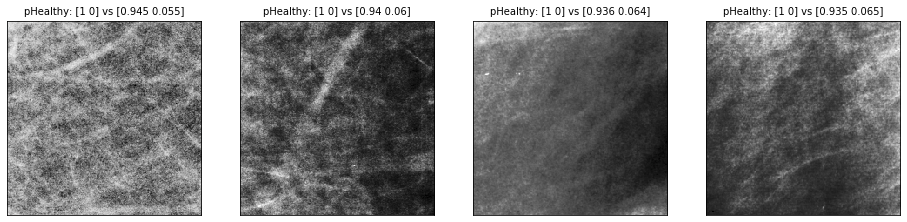

In [32]:
plot_val_with_title(most_by_correct(0, True), "Most correct healthy")

[0.623 0.66  0.702 0.782 0.754]
(390,)
----------------------------- Most correct malignant ----------------------------------------
fnImages:
 ['test/Calc-Test_P_00497_LEFT_CC_tile_605_331.png' 'test/Calc-Test_P_00497_LEFT_CC_tile_599_308.png'
 'test/Calc-Test_P_01390_RIGHT_CC_tile_288_270.png' 'test/Calc-Test_P_01390_RIGHT_CC_tile_229_312.png']


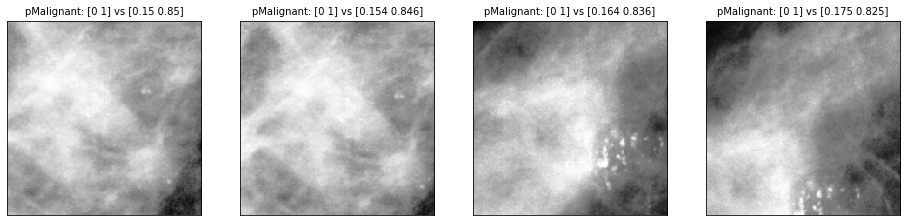

In [33]:
plot_val_with_title(most_by_correct(1, True), "Most correct malignant")

[0.488 0.451 0.269 0.452 0.423]
(110,)
----------------------------- Most incorrect malignant ----------------------------------------
fnImages:
 ['test/Calc-Test_P_01471_RIGHT_MLO_tile_1135_1.png' 'test/Calc-Test_P_00570_LEFT_MLO_tile_1291_471.png'
 'test/Calc-Test_P_01471_RIGHT_MLO_tile_1139_2.png' 'test/Calc-Test_P_01471_RIGHT_MLO_tile_1155_5.png']


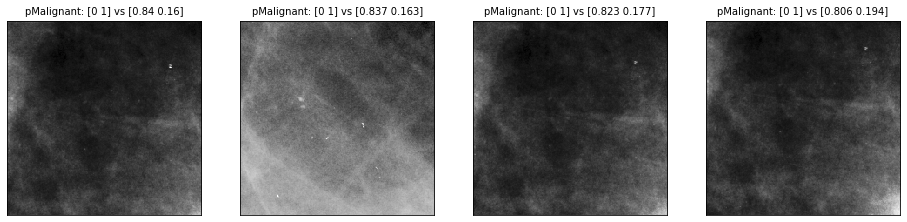

In [34]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect malignant")

[0.424 0.496 0.491 0.309 0.392]
(148,)
----------------------------- Most incorrect healthy ----------------------------------------
fnImages:
 ['test/Calc-Test_P_00495_RIGHT_MLO_tile_1120_224.png' 'test/Calc-Test_P_00460_LEFT_MLO_tile_896_448.png'
 'test/Calc-Test_P_00495_RIGHT_MLO_tile_1120_448.png' 'test/Calc-Test_P_00402_RIGHT_CC_tile_672_634.png']


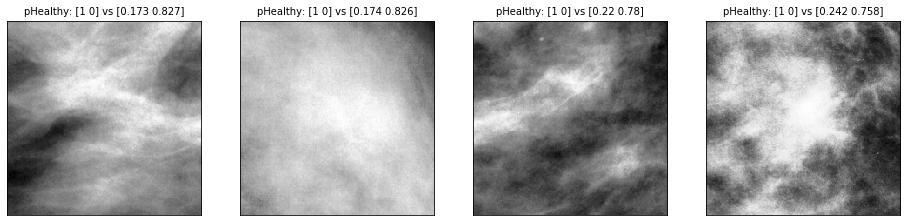

In [35]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect healthy")

----------------------------- Most uncertain predictions ----------------------------------------
fnImages:
 ['test/Calc-Test_P_00214_LEFT_MLO_tile_896_224.png' 'test/Calc-Test_P_00537_RIGHT_MLO_tile_1120_448.png'
 'test/Calc-Test_P_00485_LEFT_MLO_tile_1344_1120.png' 'test/Calc-Test_P_00038_RIGHT_CC_tile_448_375.png']


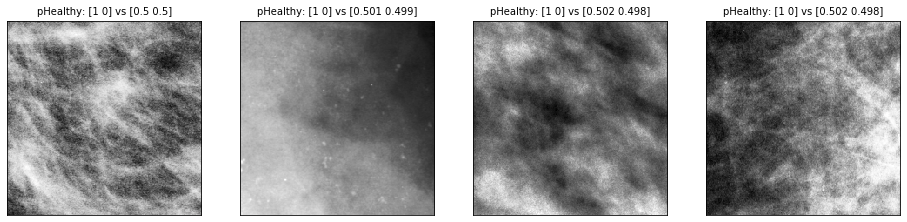

In [36]:
plot_val_with_title(mostUncertain(4), "Most uncertain predictions")

meatadata for layer:  Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
One image with all n filterweight with size  64 7 7


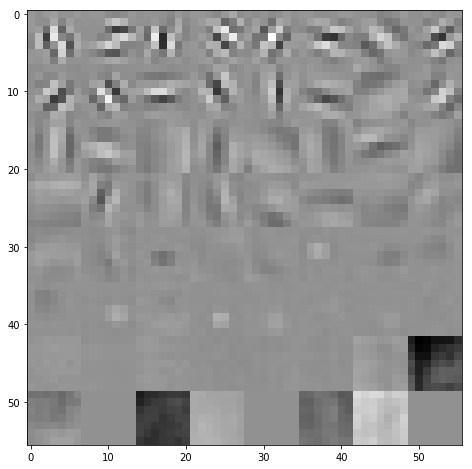

In [37]:
def plotTensor( im ):       
    colorMap = plt.cm.gray if im.ndim == 2 else None 
    
    fig = plt.figure(figsize=(8,8)) 
    plt.imshow(im, cmap=colorMap)    
    plt.show()
    
def createFilterImage( weights ) :   
    #scale to 0-1 and put the channel in the last as expect by matplotlib
    weights = 0.5*np.copy(weights+1.0)
    weights = np.rollaxis(weights, 1, 4)
    
    filter_dim = weights.shape[1]
    dim = int( 0.5+ np.sqrt( weights.shape[0] ) ) * filter_dim
    
    im = np.zeros([dim,dim,weights.shape[3]])
    for i in range(8):
        io = i*filter_dim
        for j in range(8):
            jo = j*filter_dim            
            i_filter = i*(filter_dim+1) + j
            #print( "\ni_filter: {}:  i_off: {} - {},  j_off: {} - {}",  i_filter, io, (io+filter_dim), jo,(jo+filter_dim) )
            im[io:(io+filter_dim), jo:(jo+filter_dim), :] = weights[i_filter,:,:,:]

    im = np.squeeze(im)        
    return im, filter_dim

def printWeight( trainingsModel, i0, i1 ):
    layers = list( trainingsModel.getModule().children() )[i0:i1]
 
    for l in layers:        
        print("meatadata for layer: ", l)
        w = l.weight.data.cpu().numpy()
        im, filter_dim = createFilterImage(w)
        print("One image with all n filterweight with size ", w.shape[0], filter_dim, filter_dim )
        #print("\nweights.shape :", w.shape, " - weights:\n", w)
        plotTensor(im)
    
printWeight(learn.models, 0, 1)

In [38]:
def get_augs(iaug):
#    data = ImageClassifierData.from_paths(imageReader, PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

xs[0]: [[[1.18388 1.16738 1.12715 ... 1.32221 1.27793 1.21668]
  [1.21452 1.19597 1.15033 ... 1.37805 1.32705 1.23898]
  [1.23421 1.18788 1.15967 ... 1.41411 1.38601 1.27961]
  ...
  [0.33392 0.36862 0.34052 ... 1.41795 1.42436 1.41905]
  [0.32439 0.37636 0.34707 ... 1.34432 1.37057 1.39053]
  [0.31558 0.3946  0.35072 ... 1.35658 1.35682 1.36153]]]
xs2[0]: [[[-1.18388 -1.16738 -1.12715 ... -1.32221 -1.27793 -1.21668]
  [-1.21452 -1.19597 -1.15033 ... -1.37805 -1.32705 -1.23898]
  [-1.23421 -1.18788 -1.15967 ... -1.41411 -1.38601 -1.27961]
  ...
  [-0.33392 -0.36862 -0.34052 ... -1.41795 -1.42436 -1.41905]
  [-0.32439 -0.37636 -0.34707 ... -1.34432 -1.37057 -1.39053]
  [-0.31558 -0.3946  -0.35072 ... -1.35658 -1.35682 -1.36153]]]
----------------------------- RandomSelfMixin ----------------------------------------
----------------------------- RandomSelfMixin ----------------------------------------


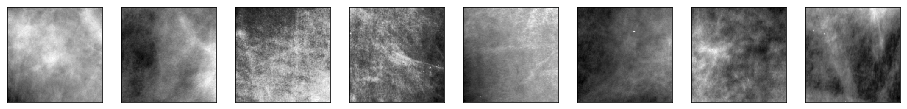

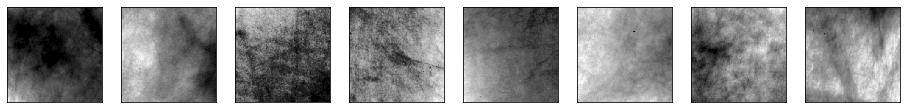

In [39]:
# mixing with a transformed copy of th image
    
def load_transImages(ds, tf, idxs): 
    xs,ys = zip(*[ ds.get1item(i) for i in idxs ])
    tf.set_state()
    print("xs[0]:",xs[0])
    xs_before = [ x.copy() for x in xs ]
    xs =  [ tf.do_transform(x,False) for x in xs ]
    print("xs2[0]:",xs[0])
    
    xs_before =  [ np.squeeze( np.clip( ds.denorm(x)[0], 0.01, 1 )) for x in xs_before ]
    xs        =  [ np.squeeze( np.clip( ds.denorm(x)[0], 0.01, 1 )) for x in xs ]
#    print("xs3[0]:",xs[0])
    
#    xs =  [ np.squeeze( np.clip( ds.denorm(tf.do_transform(x,False) )[0], 0, 1 ) ) for x in xs ]
    return xs, xs_before

#selfMixin = RandomSelfMixin(mixRatio=0.1, prob=1)
z  = RandomZoom(zoom_max=.02, zoom_min=0)
ih = RandomInverseHistogram(prob=1)
tf = ih
idxs = np.arange(8)
ims, ims_before = load_transImages(data.trn_ds, tf, idxs)
#print("ims.shape:", ims)
plots("RandomSelfMixin", ims_before, figsize=(16,4), rows=1, titles=None)
plots("RandomSelfMixin", ims, figsize=(16,4), rows=1, titles=None)
